In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy.optimize import curve_fit, minimize
from scipy.integrate import odeint

Finding out what is the total population number M, and the total number of infected people per day:

103
M = 210147125
t = [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102]
i = [1.00000e+00 1.00000e+00 1.00000e+00 2.00000e+00 2.00000e+00 2.00000e+00
 2.00000e+00 3.00000e+00 8.00000e+00 1.30000e+01 1.90000e+01 2.40000e+01
 2.90000e+01 3.40000e+01 5.40000e+01 9.00000e+01 1.09000e+02 1.45000e+02
 2.26000e+02 2.96000e+02 3.50000e+02 5.29000e+02 6.49000e+02 9.86000e+02
 1.20400e+03 1.61200e+03 1.96000e+03 2.25500e+03 2.54900e+03 2.98900e+03
 3.47600e+03 3.93100e+03 4.32000e+03 4.66200e+03 5.83200e+03 6.92700e+03
 8.08600e+03 9.21200e+03 1.03820e+04 1.12940e+04 1.22400e+04 1.41420e+04
 1.62420e+04 1.82560e+04 1.99450e+04 2.09920

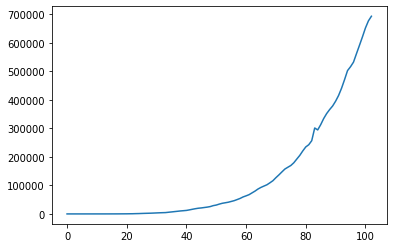

In [2]:
with open("../COVID-19_Brazil/DATA/COVID-19_Brazil_CONFIRMED.csv",'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    M = 0
    
    days = 103
    
    print(days)
    
    
    t = np.arange(days)
    linecounter = 0
    i = np.zeros(days)
    
    for row in reader:
        if linecounter > 0:
            M += int(row[3])
        columncounter = 0
        while columncounter < len(row):
            if linecounter > 0:
                if columncounter >= 6 and columncounter <= len(row)-1:
                    if row[columncounter] == "NA":
                        row[columncounter] = row[columncounter-1]
                    i[columncounter - 6] += int(row[columncounter])
            columncounter +=1
            
        
        linecounter += 1
    
    
        
    print("M =", M)
    print("t =", t)
    print("i =", i)
    plt.plot(t, i)

In [23]:
# define the ODE system for the SIR model, where i = variables[0] and r = variables[1]
def SIR(alpha, gamma, variables):
    didt = gamma * (1- (variables[0]+variables[1])/M ) * variables[0] - alpha * variables[0]
    drdt = alpha * variables[0]
    return [didt,drdt]

# functions to find the number of infected people with certain parameters
def ModelSolver(t,alpha,gamma,InitialConditions):
    
    def LocalModel(InitialConditions,t):
        
        return SIR(alpha,gamma,InitialConditions)
    
    Solution=odeint(LocalModel,InitialConditions,t)
    
    return Solution[:,1]

def SIRModelFit(t,alpha,gamma):
    
    return ModelSolver(t,alpha,gamma,initialConditions)

alpha =  32.60612368061433 , gamma =  32.688957846963696


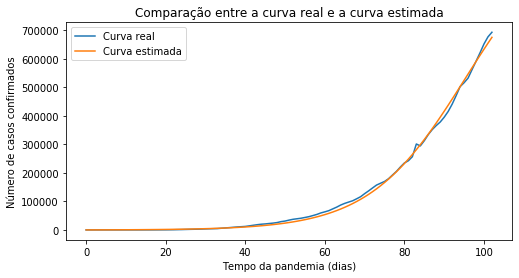

In [34]:
# choosing i(0) = 1 and r(0) = 0
initialConditions = [1,0]

# finding the best values for alpha and gamma that minimize the square error
modelParams = curve_fit(SIRModelFit,t,i)

# solving the model for the parameters found
i2 = ModelSolver(t,modelParams[0][0],modelParams[0][1],Int)
print("alpha = ", modelParams[0][0], ", gamma = ", modelParams[0][1])

# plot the number of infected people per day
plt.figure(1, figsize=(8,4))
plt.title("Comparação entre a curva real e a curva estimada")
plt.xlabel('Tempo da pandemia (dias)')
plt.ylabel('Número de casos confirmados')
plt.plot(t,i,i2)
plt.legend(("Curva real", "Curva estimada"))
plt.savefig('SIR.png')